# Relative strength index (RSI)

In [1]:
import os
setup_script = os.path.join(os.environ['ENV_JUPYTER_SETUPS_DIR'], 'setup_sci_env_basic.py')
%run $setup_script

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.__version__

'0.20.3'

In [3]:
load_mpl_style('single_plot.mplstyle')
ignore_warnings()

**Relative strength index (RSI)** is defined as:


$$
\begin{equation}
\text{RSI}
=
100
-
\frac{100}{1+RS}
\end{equation}
$$

To construct he RSI we need to calculate the relative strength $\text{RS}$, which is:

$$
\begin{equation}
\text{RS}
=
\frac{MA(U,n)}{MA(D,n)}
\end{equation}
$$

$MA(x,n)$ is a moving average function which could be the:
- Uniformly weighted moving average:
    $$
    \begin{equation}
    \text{UWMA}(x,n) = \frac{\sum_{i} p_{i}}{n}
    \end{equation}
    $$
    
    Here $i$ goes over the last $n$ periods inclusive of $x$, that is $x$: $i=x,x-1,x-2,x-(n-1)$.
    
- Exponentially weighted moving average:
    $$
    \begin{equation}
    \text{EWMA}(x,n) = \frac{\sum_{i} w_{i} p_{i} }{\sum w_{i}}
    \end{equation}
    $$
    
    Here $w_{i}$ is the expoential weight, $w_{i}= (1-\alpha)^{x-i}$, and $i$ goes over the entire past periods inclusive of $x$, that is $i$: $i=x,x-1,x-2,x-3,...$. The prices are weighted by some power of $(1-\alpha)$, where $\alpha$ is the decay parameter ($0 \leq \alpha < 1$). The current price, $p_{x}$ receives a full weight of $(1-\alpha)^{x-x}=1$, whereas the prices further and further from the current price in past have smaller and smaller weights. E.g. a price $n$ periods in past has a weight of $(1-\alpha)^{x-(x-n))} = (1-\alpha)^{n}$.

    Some alternative ways to define the decay parameter:
    
    - center of mass:
        \begin{equation}
        \alpha = \frac{1}{1 + \text{center of mass}}
        \end{equation}

    - span:
        \begin{equation}
        \alpha = \frac{2}{1 + \text{span}}
        \end{equation}
    
    - half-life, $\tau_{1/2}$
        $$
        \begin{equation}
        \alpha = 1 - \exp\left[\log_{0.5} (\tau_{1/2})\right]
        \end{equation}
        $$

The upward change, $U$ and downward change, $D$ are the absolute values of the changes in up and down days:

\begin{equation}
\begin{aligned}
    U
    &=
    \theta(\text{price}_{now} - \text{price}_{previous})
    \\
    D
    &=
    \theta(\text{price}_{previous} - \text{price}_{now})
\end{aligned}
\end{equation}

Note that $U=0$ when there is a down day, and $D=0$ when there is an up day.

- up day: $\text{price}_{now} > \text{price}_{previous}$
- down day: $\text{price}_{now} < \text{price}_{previous}$


**References:**
- https://en.wikipedia.org/wiki/Relative_strength_index
- https://www.investopedia.com/terms/r/rsi.asp
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html
- http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows

Load FTSE100 tickers

In [4]:
ftse100 = pd.read_csv('./ftse100_tickers.dat')

Load and merge price data

In [5]:
df = pd.DataFrame()
for ticker in ftse100['ticker']:
    df_ = pd.read_csv('./data/{}.dat'.format(ticker))
    df_['ticker'] = ticker
    if df.empty:
        df = df_
    else:
        df = df.append(df_)

In [6]:
df.set_index(['ticker', 'Date'], inplace=True)

Selecting a single security and width of the rolling window

In [7]:
security = 'BARC.L'

Create an array of the daily price differences:

In [8]:
close = df.loc[security]['Adj Close']
delta = close.diff()
delta[0] = 0

In [9]:
start = -14

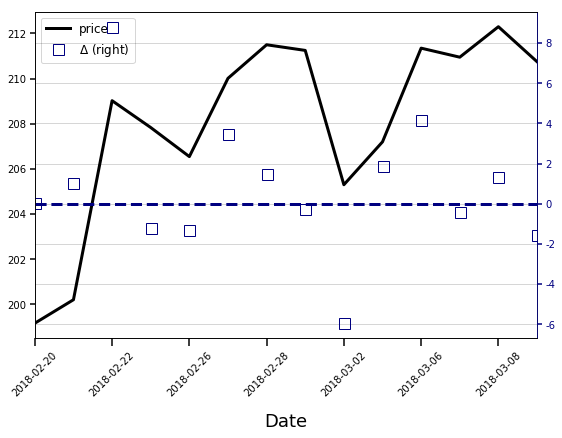

In [10]:
a1 = close[start:].plot(rot=45, label='price', c='k', legend=True)
a2 = delta[start:].plot(secondary_y=True, rot=45, label=r'$\Delta$', c='navy', style='s', markersize=11, markerfacecolor='none', legend=True)
a1.spines['left'].set_color('k')
a2.spines['right'].set_color('navy')
a1.tick_params(axis='y', colors='k')
a2.tick_params(axis='y', colors='navy')
a2.hlines(y=0, xmin=0, xmax=100, colors='navy', linestyle='--')

Create the positive gains (up) and negative gains (down)

In [11]:
up, down = delta.copy(), delta.copy()
up[up < 0] = 0 
down[down > 0] = 0 

In [12]:
start = -14

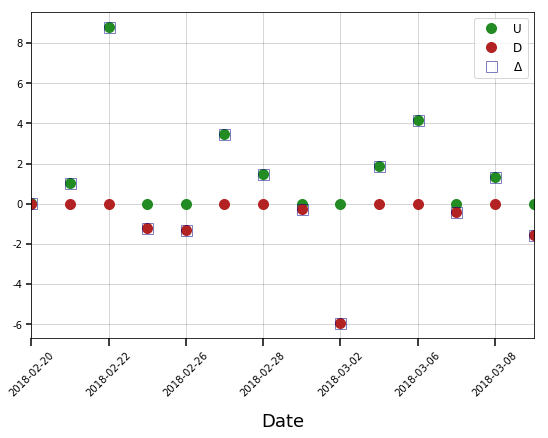

In [13]:
f,a = plt.subplots()
up[start:].plot(ax=a, label='U', style='o', markersize=10, c='forestgreen', legend=True)
down[start:].plot(ax=a, label='D', style='o', markersize=10, c='firebrick', legend=True)
delta[start:].plot(ax=a, label=r'$\Delta$', style='s', markerfacecolor='none',  markersize=11, c='navy', rot=45, alpha=0.5, legend=True)
plt.legend();

### Moving averages

In [14]:
window = 14

In [15]:
roll_uwma_up   = pd.rolling_mean(up, window)
roll_uwma_down = pd.rolling_mean(down.abs(), window)

In [16]:
roll_ewma_up   = pd.stats.moments.ewma(up, window)
roll_ewma_down = pd.stats.moments.ewma(down.abs(), window)

In [17]:
#roll_ewma_up = up.ewm(window)
#roll_ewma_down = down.ewm(window)
#roll_ewma_up = pd.ewma(up, window)
#roll_ewma_down = pd.ewma(down.abs(), window)

In [18]:
start = -50

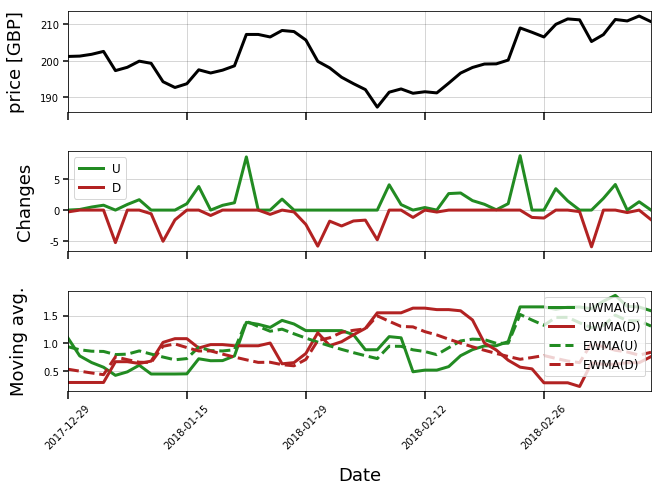

In [19]:
f,(a1,a2,a3) = plt.subplots(nrows=3)
f.tight_layout()
close[start:].plot(ax=a1, rot=45, c='k')
up[start:].plot(ax=a2, c='forestgreen', label='U', legend=True)
down[start:].plot(ax=a2, c='firebrick', label='D', legend=True)
roll_uwma_up[start:].plot(ax=a3, rot=45, label='UWMA(U)', c='forestgreen', linestyle='-', legend=True)
roll_uwma_down[start:].plot(ax=a3, label='UWMA(D)', c='firebrick', linestyle='-', legend=True)
roll_ewma_up[start:].plot(ax=a3, label='EWMA(U)', c='forestgreen', linestyle='--', legend=True)
roll_ewma_down[start:].plot(ax=a3, rot=45, label='EWMA(D)', c='firebrick', linestyle='--', legend=True)
a1.set_xlabel('')
a1.set_xticklabels('')
a1.set_ylabel('price [GBP]')
a2.set_xlabel('')
a2.set_xticklabels('')
a2.set_ylabel('Changes')
a3.set_ylabel('Moving avg.');

#### Sanity check

##### UWMA

In [20]:
uwma_up_manual = up[-14:].sum()/window
uwma_down_manual = down[-14:].abs().sum()/window
uwma_up = roll_uwma_up[-1]
uwma_down = roll_uwma_down[-1]

In [21]:
print("U_avg_manual: {} uwma_up: {}".format(uwma_up_manual, uwma_up))
print("D_avg_manual: {} uwma_down: {}".format(uwma_down_manual, uwma_down))

U_avg_manual: 1.5899636428571426 uwma_up: 1.5899636428571426
D_avg_manual: 0.7590419285714286 uwma_down: 0.7590419285714286


In [38]:
if (abs(uwma_up_manual - uwma_up) < 1e-5) and (abs(uwma_down_manual - uwma_down) < 1e-5):
    print("Uniform weighted average (UWMA) validated.")

Uniform weighted average (UWMA) validated.


##### EWMA

In [22]:
n_entire_past = len(up)

In [23]:
com = 14

In [24]:
alpha = 1.0/(1.0+com)
print('alpha: {}'.format(alpha))

alpha: 0.06666666666666667


In [25]:
weights = [(1.0-alpha)**((n_entire_past-1)-i) for i in range(n_entire_past)]

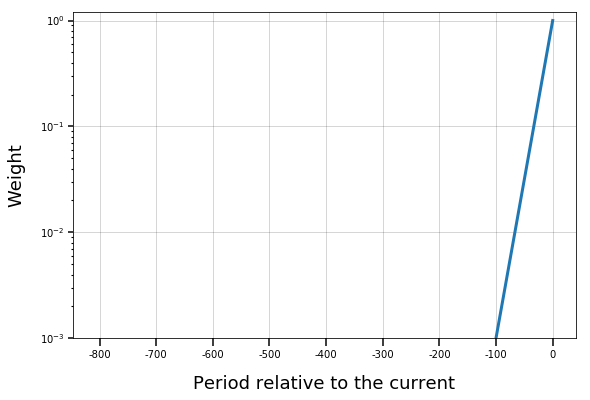

In [26]:
f,a = plt.subplots()
a.plot(range(-(n_entire_past-1), 1, 1), weights)
a.set_xlabel('Period relative to the current')
a.set_ylabel('Weight');
a.set_ylim(1e-3,1.2);
a.set_yscale('log')

In [27]:
ewma_up_manual   = np.dot(up, weights)/np.sum(weights)
ewma_down_manual = np.dot(down.abs(), weights)/np.sum(weights)
ewma_up   = roll_ewma_up[-1]
ewma_down = roll_ewma_down[-1]

In [28]:
print("EWMA_avg_manual: {} EWMA_up: {}".format(ewma_up_manual, ewma_up))
print("EWMA_avg_manual: {} EWMA_down: {}".format(ewma_down_manual, ewma_down))

EWMA_avg_manual: 1.312194092817974 EWMA_up: 1.3121940928179736
EWMA_avg_manual: 0.8370012616049095 EWMA_down: 0.837001261604909


In [40]:
if (abs(ewma_up_manual - ewma_up) < 1e-5) and (abs(ewma_down_manual - ewma_down) < 1e-5):
    print("Exponential weighted average (ewma) validated.")

Exponential weighted average (ewma) validated.


### Relative strength (RS)

Calculate the $\text{RS}$ as the ratio of the moving averages of the upward and downward changes:

$$
\begin{equation}
    RS = \frac{MA(U,n)}{MA(D,n)}
\end{equation}
$$

In [29]:
RS_uwma = roll_uwma_up / roll_uwma_down
RS_ewma = roll_ewma_up / roll_ewma_down

In [30]:
start = -100

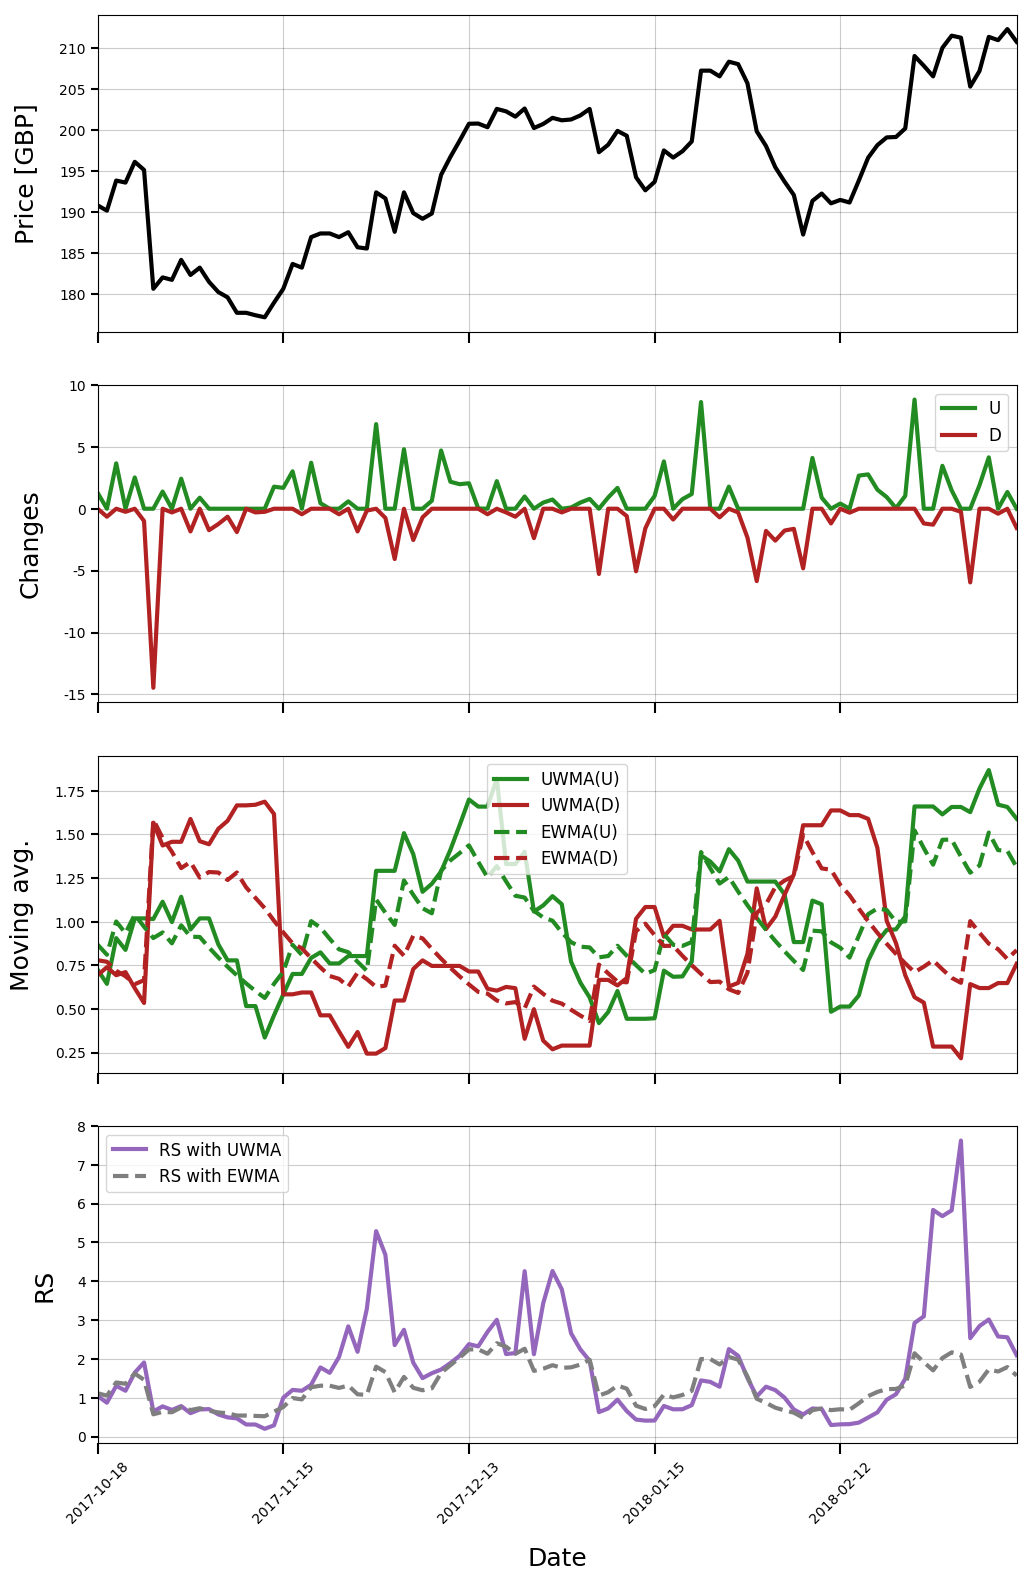

In [31]:
f,(a1,a2,a3,a4) = plt.subplots(nrows=4, figsize=(10.0,15.0), dpi=100)
f.tight_layout()
close[start:].plot(ax=a1, c='k')
up[start:].plot(ax=a2, c='forestgreen', label='U', legend=True)
down[start:].plot(ax=a2, c='firebrick', label='D', legend=True)
roll_uwma_up[start:].plot(ax=a3, rot=45, label='UWMA(U)', c='forestgreen', linestyle='-', legend=True)
roll_uwma_down[start:].plot(ax=a3, label='UWMA(D)', c='firebrick', linestyle='-', legend=True)
roll_ewma_up[start:].plot(ax=a3, label='EWMA(U)', c='forestgreen', linestyle='--', legend=True)
roll_ewma_down[start:].plot(ax=a3, rot=45, label='EWMA(D)', c='firebrick', linestyle='--', legend=True)
RS_uwma[start:].plot(label='RS with UWMA', ax=a4, c='C4', linestyle='-', legend=True, rot=45)
RS_ewma[start:].plot(label='RS with EWMA', ax=a4, c='C7', linestyle='--', legend=True, rot=45)
a1.set_xlabel('')
a1.set_xticklabels('')
a1.set_ylabel('Price [GBP]')
a2.set_xlabel('')
a2.set_xticklabels('')
a2.set_ylabel('Changes')
a3.set_xlabel('')
a3.set_xticklabels('')
a3.set_ylabel('Moving avg.')
a4.set_ylabel('RS');

### Constructing $\text{RSI}$

$$
\begin{equation}
    \text{RSI} = 100 - \frac{100}{1 + \text{RS}}
\end{equation}
$$

In [32]:
RSI_uwma = 100.0 - (100.0 / (1.0 + RS_uwma))
RSI_ewma = 100.0 - (100.0 / (1.0 + RS_ewma))

In [33]:
start = -200

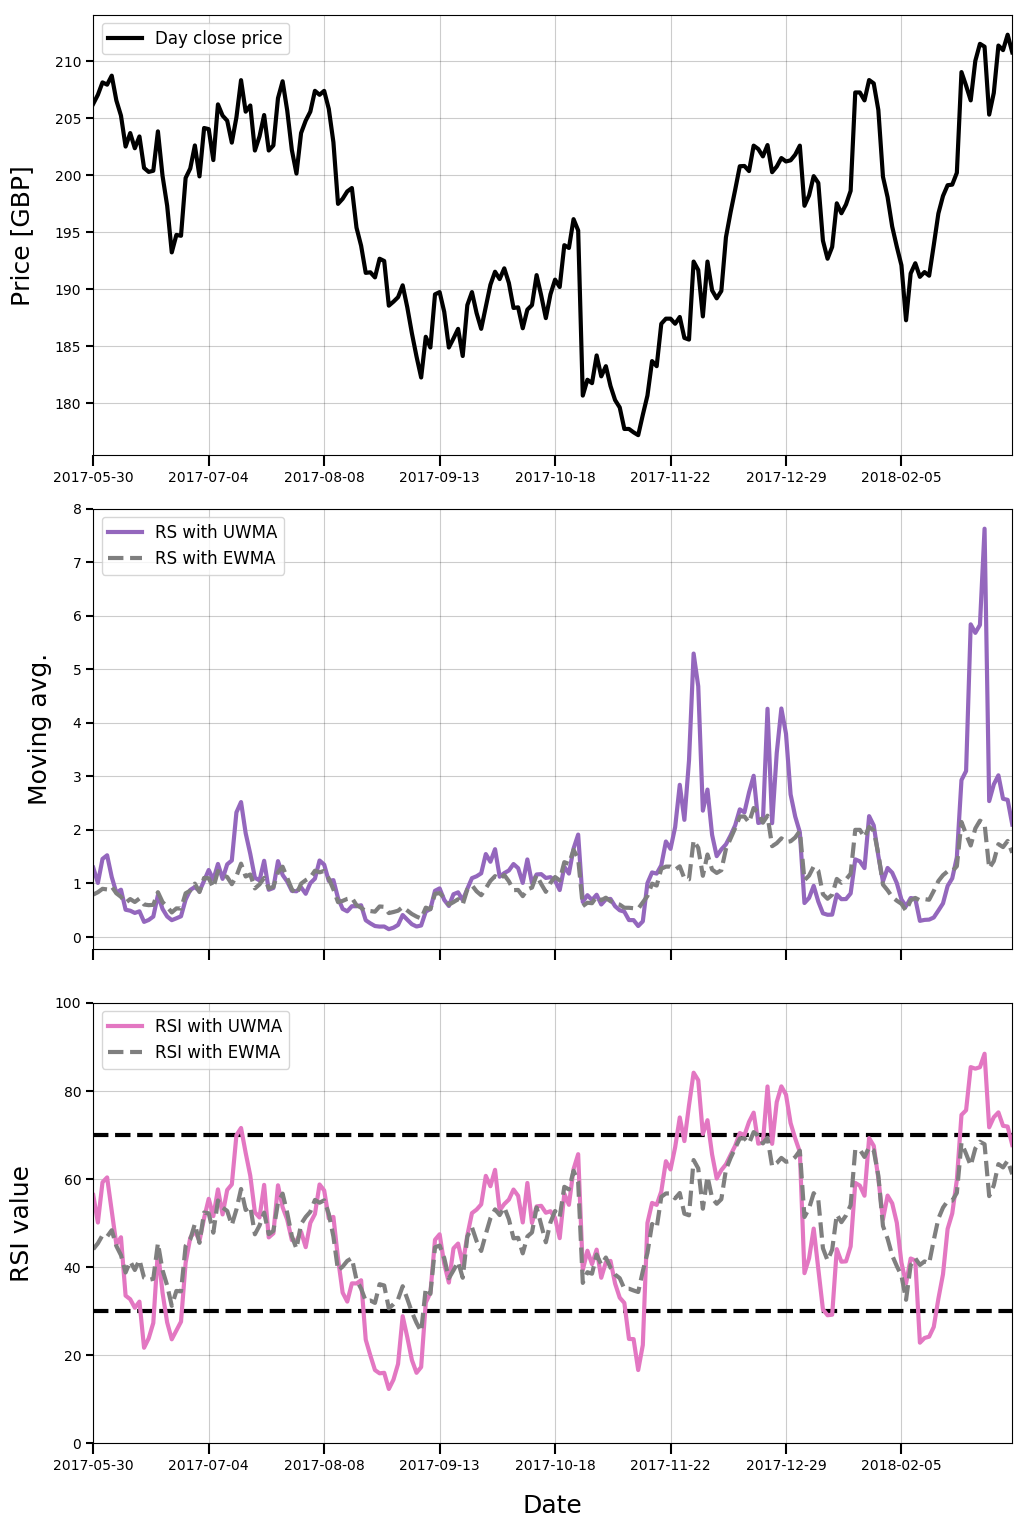

In [34]:
f,(a1,a2,a3) = plt.subplots(nrows=3, figsize=(10,15), dpi=100)
f.tight_layout()
#f.subplots_adjust(top=0.9)
close[start:].plot(ax=a1, c='k', label='Day close price', legend=True)
RS_uwma[start:].plot(label='RS with UWMA', ax=a2, c='C4', linestyle='-', legend=True, rot=45)
RS_ewma[start:].plot(label='RS with EWMA', ax=a2, c='C7', linestyle='--', legend=True, rot=45)
RSI_uwma[start:].plot(ax=a3, c='C6', linestyle='-', label='RSI with UWMA', legend=True)
RSI_ewma[start:].plot(ax=a3, c='C7', linestyle='--', label='RSI with EWMA', legend=True)
a1.set_xlabel('')
a1.set_ylabel('Price [GBP]')
a2.set_xlabel('')
a2.set_xticklabels('')
a2.set_ylabel('Moving avg.')
a3.set_ylim(0, 100)
a3.set_ylabel('RSI value')
a3.hlines(30, 0, 1e3, linestyles='--', label='30')
a3.hlines(70, 0, 1e3, linestyles='--', label='70');

Note that:
- There are many false buy and sell triggers (RSI < 30, RSI > 70)
- UWMA seem to be more volatile relative to EWMA